# Create XAIs

In [9]:
import os
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

from skimage.transform import AffineTransform, warp
from torchvision import transforms
from tqdm import tqdm

from models import *
from utils.utils import load_config, create_folder
from XAI import IntegratedGradients, GradCAM, attribution_mask_processing
from XAI.metrics import overlap_schiller, IoU

import gc

import warnings

warnings.filterwarnings('ignore')

In [10]:
device = 'cuda'
folder = 'UNIFESP+iCOPE'
model = 'NCNN_PRETRAINED'

path_experiments = f'experiments\\{folder}\\{model}'
path_masks = os.path.join(path_experiments, 'xai_masks')
path_TP = os.path.join(path_experiments, 'xai_masks', 'TP')
path_TN = os.path.join(path_experiments, 'xai_masks', 'TN')
path_FP = os.path.join(path_experiments, 'xai_masks', 'FP')
path_FN = os.path.join(path_experiments, 'xai_masks', 'FN')

path_mean_XAI = os.path.join(path_experiments, 'xai_masks', 'mean_masks')

path_mesh = 'Datasets\\landmarks'

In [11]:
if "VGGNB" in model:
    filename = 'results_MCDP_0.5_30.pkl'
else:
    filename = 'results_MCDP_0.1_30.pkl'

filename = 'results.pkl'
with open(os.path.join(path_experiments,filename), 'rb') as f:
    results = pickle.load(f)

In [12]:
probs_array = []
img_names = []
labels_array = []
preds_array = []
folds = []

for i, fold in enumerate(results.keys()):
    preds = results[fold]['preds']
    labels = results[fold]['labels']
   
    img_names.extend(results[fold]['img_names'])
    labels_array.extend(labels)
    preds_array.extend(preds)

    probs_array.extend(results[fold]['probs'])

    folds.extend([i] * len(preds))

In [13]:
dataframe = pd.DataFrame({'fold': folds, 'img_names': img_names, 'labels':labels_array, 'preds': preds_array, 'probs':probs_array})

In [14]:
dataframe

,fold,img_names,labels,preds,probs
0,0,Datasets\Folds\0\Test\ID1014_UNIFESP_S92_nopai...,0,0,0.083567
1,0,Datasets\Folds\0\Test\ID1015_UNIFESP_S92_nopai...,0,0,0.134429
2,0,Datasets\Folds\0\Test\ID1016_UNIFESP_S92_nopai...,0,0,0.062091
3,0,Datasets\Folds\0\Test\ID1017_UNIFESP_S92_nopai...,0,0,0.022508
4,0,Datasets\Folds\0\Test\ID1018_UNIFESP_S92_nopai...,0,0,0.009300
...,...,...,...,...,...
516,9,Datasets\Folds\9\Test\ID973_UNIFESP_S88_nopain...,0,0,0.075543
517,9,Datasets\Folds\9\Test\ID974_UNIFESP_S88_nopain...,0,0,0.020564
518,9,Datasets\Folds\9\Test\ID975_UNIFESP_S88_pain.jpg,1,0,0.204899
519,9,Datasets\Folds\9\Test\ID976_UNIFESP_S88_pain.jpg,1,0,0.286917


## Generate TP,TN,FP,FN XAIs

In [15]:
create_folder(path_masks)
create_folder(path_TP)
create_folder(path_TN)
create_folder(path_FP)
create_folder(path_FN)
create_folder(path_mean_XAI)

In [17]:

# Define your batch size (adjust based on your memory/GPU capacity)
BATCH_SIZE = 32

for exp in os.listdir(path_experiments):
    # Skip non-experiment folders/files.
    if any(ext in exp for ext in ['.pkl', 'masks', '.png', '.pdf']):
        continue

    # Load model and configuration.
    path_model = os.path.join(path_experiments, exp, 'Model', 'best_model.pt')
    path_yaml  = os.path.join(path_experiments, exp, 'Model', 'config.yaml')
    config     = load_config(path_yaml)
    test_path  = config['path_test']
    fold       = test_path.split('\\')[-2]

    # Set up the model, transforms, and attribution objects based on experiment type.
    if "NCNN" in exp:
        model = NCNN().to(device)
        img_size = 120
        ## CHANGED HERE!!!
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.52026823, 0.40445255, 0.34655508],
                                std=[0.28127891, 0.24436931, 0.23583611])
                
        ])
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.conv_4, device=device)
    elif "VGGNB" in exp:
        model = VGGNB().to(device)
        img_size = 224
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((img_size, img_size), antialias=False),
            transforms.Normalize(mean=[0.36703529, 0.41083294, 0.50661294],
                                 std=[1, 1, 1])
        ])
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)
    elif "ViTNB" in exp:
        model = ViTNB().to(device)
        img_size = 224
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((img_size, img_size), antialias=False),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model,
                          model.ViT.encoder.layers.encoder_layer_11.ln_1,
                          device=device,
                          reshape_transform_ViT=True)
    else:
        continue

    # Load the trained weights and set the model to evaluation mode.
    model.load_state_dict(torch.load(path_model))
    model.eval()

    # Get list of test images.
    image_files = [f for f in os.listdir(test_path) if f.endswith('.jpg')]

    # Process images in batches.
    for batch_start in tqdm(range(0, len(image_files), BATCH_SIZE)):
        batch_files = image_files[batch_start: batch_start + BATCH_SIZE]
        transformed_list = []   # List of transformed tensors for the batch.
        rgb_list         = []   # List of RGB images (for plotting).
        meta_data        = []   # List of metadata tuples: (img_name, label, pred, prob, full_img_path).

        for img_file in batch_files:
            full_img_path = os.path.join(test_path, img_file)
            # Read image via OpenCV.
            #img_bgr = cv2.imread(full_img_path)
            # Resize to the required dimensions.
            #img_bgr = cv2.resize(img_bgr, (img_size, img_size))
            # Convert BGR to RGB.
            #img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            img_rgb = Image.open(os.path.join(full_img_path)).convert("RGB")
            img_rgb = img_rgb.resize((img_size, img_size))
            
            img_name = img_file.split(".jpg")[0]
            # Extract label from the filename.
            label = 1 if img_file.split(".jpg")[0].split("_")[3] == 'pain' else 0

            # For some experiments (NCNN, ViTNB) the image is directly used;
            # otherwise, use the RGB image (as in VGGNB).
            if "NCNN" in exp or "ViTNB" in exp:
                img_input = img_rgb
            #else:
                #img_input = img_bgr

            # Normalize the image.
            #img_input = img_input / 255.0
            #img_input = np.float32(img_input)

            # Apply the transform.
            transformed = transform(img_input)
            transformed_list.append(transformed)
            rgb_list.append(img_rgb)

            # Retrieve probability from your dataframe.
            prob = dataframe[dataframe['img_names'] == full_img_path]['probs'].values[0]
            pred = 1 if prob >= 0.5 else 0

            meta_data.append((img_name, label, pred, prob, full_img_path))

        # Stack the batch of images: shape becomes (B, C, H, W).
        batch_tensor = torch.stack(transformed_list, dim=0).to(device)

        # Compute the attribution masks in batch.
        masks_ig = ig.attribution_mask(batch_tensor)   # Expected shape: (B, H, W)
        masks_gc = gradcam.attribution_mask(batch_tensor)  # Expected shape: (B, H, W)

        # Loop over each image in the batch to post-process, save, and plot.
        for i in range(len(batch_files)):
            (img_name, label, pred, prob, full_path) = meta_data[i]
            mask_ig_i = masks_ig[i]
            mask_gc_i = masks_gc[i]

            # Determine the correct save directory based on label and prediction.
            if (label == pred) and label == 1:
                save_path = path_TP
            elif (label == pred) and label == 0:
                save_path = path_TN
            elif (label != pred) and label == 1:
                save_path = path_FN
            elif (label != pred) and label == 0:
                save_path = path_FP

            # Save the attribution masks as pickle files.
            ig_pkl_name   = f"{img_name}_IG_{label}_{pred}_{prob:.4f}.pkl"
            gc_pkl_name   = f"{img_name}_GC_{label}_{pred}_{prob:.4f}.pkl"
            with open(os.path.join(save_path, ig_pkl_name), 'wb') as f:
                pickle.dump(mask_ig_i, f)
            with open(os.path.join(save_path, gc_pkl_name), 'wb') as f:
                pickle.dump(mask_gc_i, f)

            # Apply post-processing to get results for plotting.
            result_ig, alpha_channel_ig = attribution_mask_processing(mask_ig_i, use_mini_batch=False)
            result_gc, alpha_channel_gc = attribution_mask_processing(mask_gc_i, use_mini_batch=False)
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

            # Plot and save the Integrated Gradients overlay.
            ig_png_name = f"{img_name}_IG_{label}_{pred}_{prob:.4f}.png"
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_list[i])
            plt.imshow(result_ig, cmap=cmap, alpha=alpha_channel_ig)
            plt.axis('off')
            plt.savefig(os.path.join(save_path, ig_png_name), dpi=300, bbox_inches='tight')
            plt.close()

            # Plot and save the GradCAM overlay.
            gc_png_name = f"{img_name}_GC_{label}_{pred}_{prob:.4f}.png"
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_list[i])
            plt.imshow(result_gc, cmap=cmap, alpha=alpha_channel_gc)
            plt.axis('off')
            plt.savefig(os.path.join(save_path, gc_png_name), dpi=300, bbox_inches='tight')
            plt.close()

    # Cleanup after processing each experiment.
    gc.collect()
    torch.cuda.empty_cache()


100%|██████████| 2/2 [00:30<00:00, 15.48s/it]


In [18]:
batch_tensor.shape

torch.Size([7, 3, 120, 120])

# Image and XAI alignment

In [19]:
img_names = []
dataset = []
labels = []
xai = []
preds = []
probs = []

for path in [path_TP, path_TN, path_FN, path_FP]:
    for file in os.listdir(path):
        if file.endswith('.png'):
            split = file.split("_")
            img_names.append('_'.join(split[:-4]))
            dataset.append(split[1])
            label = split[3]
            labels.append(1 if label == 'pain' else 0)
            xai.append(split[-4])
            preds.append(int(split[-2]))
            probs.append(float(split[-1].replace(".png","")))    

In [20]:
dataframe = pd.DataFrame({"img_names":img_names, "dataset":dataset, "labels":labels, "xai":xai, "preds":preds, "probs":probs})
dataframe.drop_duplicates(subset='img_names', inplace=True)

Calculate mean landmarks of already detected face mesh

In [21]:
faces = []
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

In [22]:
landmarks_mean = np.array([face_mesh_mean[86], 
                           face_mesh_mean[52],
                           face_mesh_mean[61],
                           face_mesh_mean[88],
                           face_mesh_mean[38]])

In [23]:
step = 0.1 # Step for probabilities range

stack_img = []
stack_GC = []
stack_IG = []
name = 'TP_TN'

for tipo in ['TN', 'TP', 'FN', 'FP']:

    if tipo == 'FN':
        name = 'FP_FN'
        stack_img = []
        stack_GC = []
        stack_IG = []

    if tipo == 'TP':
        new_df = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['labels'] == 1)]
        confs = np.arange(0.5, 1.01, step).round(1)
    elif tipo == 'TN':
        new_df = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['labels'] == 0)]
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FN':
        new_df = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['labels'] == 1)]
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FP':
        new_df = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['labels'] == 0)]
        confs = np.arange(0.5, 1.01, step).round(1)

    path_xai = os.path.join(path_experiments, 'xai_masks', tipo)

    scores = []
    for c in range(len(confs) - 1):
        total = new_df[(new_df['probs'] >= confs[c]) & (new_df['probs'] < confs[c+1])]['img_names'].drop_duplicates().values
        
        if len(total) > 0:

            warped_imgs = []
            warped_xai_GC = []
            warped_xai_IG = []

            for i in total:
                flag = 0
                fold = 0
                while flag == 0:
                    path = f'Datasets\\Folds\\{fold}\\Test'
                    for img_file in os.listdir(path):
                        if i in img_file:
                            img = cv2.imread(os.path.join(path, img_file))
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            flag = 1

                    fold += 1

                for xai in os.listdir(path_xai):
                    if '.pkl' in xai:
                        if '_'.join(xai.split('_')[:-4]) == i:
                            with open(os.path.join(path_xai, xai), 'rb') as f:
                                mask_GC  = pickle.load(f)

                            with open(os.path.join(path_xai, xai.replace('GC','IG')), 'rb') as f:
                                mask_IG  = pickle.load(f)

                            mask_GC = cv2.resize(mask_GC, (512,512))
                            mask_IG = cv2.resize(mask_IG, (512,512))
                        
                            break       
                if (i+".pkl") in os.listdir(path_mesh):
                    with open(os.path.join(path_mesh,f'{i}.pkl'), 'rb') as f:
                        face_mesh = np.array(pickle.load(f))
                else:
                    print('problerm')
                
                if face_mesh is not None:
                   
                    landmarks =  np.array([face_mesh[86], 
                                            face_mesh[52],
                                            face_mesh[61],
                                            face_mesh[88],
                                            face_mesh[38]])
            
                    # first align image
                    transform_rigid = AffineTransform()
                    transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
                    result = warp(img, transform_rigid) *255
                    result_mask_GC = warp(mask_GC, transform_rigid)*255
                    result_mask_IG = warp(mask_IG, transform_rigid)*255

                    warped_imgs.append(result.astype(np.uint8))
                    warped_xai_GC.append(result_mask_GC.astype(np.uint8))
                    warped_xai_IG.append(result_mask_IG.astype(np.uint8))
                                        
            mean_img = np.mean(np.array(warped_imgs), axis=0)/255
            mean_xai_GC = np.mean(np.array(warped_xai_GC), axis=0)
            mean_xai_IG = np.mean(np.array(warped_xai_IG), axis=0)

            result_cam_GC, alpha_channel_cam_GC = attribution_mask_processing(mean_xai_GC)
            result_cam_IG, alpha_channel_cam_IG = attribution_mask_processing(mean_xai_IG)

            save_name = "MEAN_GC_" + tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.pkl'
            save_path = os.path.join(path_masks, "mean_masks", save_name)
            with open(save_path, 'wb') as f:
                pickle.dump(result_cam_GC, f)

            save_name = "MEAN_IG_" + tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.pkl'
            save_path = os.path.join(path_masks, "mean_masks", save_name)
            with open(save_path, 'wb') as f:
                pickle.dump(result_cam_IG, f)


            test_gc = np.expand_dims(((result_cam_GC * alpha_channel_cam_GC) > 0).astype('int'),-1)
            test_ig = np.expand_dims(((result_cam_IG * alpha_channel_cam_IG) > 0).astype('int'),-1)

            # Define the plot colors
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

            plt.figure(figsize=(10,10))

            plt.subplot(331)
            plt.imshow(mean_img)
            plt.title('Avg')
            plt.ylabel('GC')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(332)
            plt.imshow(mean_img)
            plt.imshow(result_cam_GC, cmap=cmap, alpha=alpha_channel_cam_GC)
            plt.title('Avg XAI')
            plt.axis('off')

            plt.subplot(333)
            plt.imshow(mean_img * test_gc)
            plt.title('Face Regions')
            plt.axis('off')

            plt.subplot(334)
            plt.imshow(mean_img)
            plt.ylabel('IG')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(335)
            plt.imshow(mean_img)
            plt.imshow(result_cam_IG, cmap=cmap, alpha=alpha_channel_cam_IG)
            plt.axis('off')

            plt.subplot(336)
            plt.imshow(mean_img * test_ig)
            plt.axis('off')

            plt.tight_layout()

            save_name = tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.png'
            save_path = os.path.join(path_masks, save_name)

            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

Create stacked image

In [24]:
stack_img = []
stack_GC = []
stack_IG = []
name = 'TP_TN'

for tipo in ['TN', 'TP', 'FN', 'FP']:
    if tipo == 'TP':
        confs = np.arange(0.5, 1.01, step).round(1)
    elif tipo == 'TN':
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FN':
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FP':
        confs = np.arange(0.5, 1.01, step).round(1)

    if tipo == 'FN':
        name = 'FP_FN'
        stack_img = []
        stack_GC = []
        stack_IG = []

    for c in range(len(confs) - 1):
        p = os.path.join(path_masks, tipo+"_"+str(confs[c])+"_"+str(confs[c+1])+".png")

        try:
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mean_img = img[81:977, 89:985]
            GC = img[81:977, 1048:1944]
            IG = img[1048:1944, 1048:1944]
            
            stack_img.append(mean_img)
            stack_GC.append(GC)
            stack_IG.append(IG)

        except:
            stack_img.append(np.zeros((896,896,3), dtype='float32'))
            stack_GC.append(np.zeros((896,896,3), dtype='float32'))
            stack_IG.append(np.zeros((896,896,3), dtype='float32'))

    stack_img_x = np.hstack(stack_img)
    stack_GC_x = np.hstack(stack_GC)
    stack_IG_x = np.hstack(stack_IG)

    stack = np.vstack((stack_img_x, stack_GC_x, stack_IG_x))
    cv2.imwrite(os.path.join(path_masks,f'{name}_all.png'), cv2.cvtColor(stack, cv2.COLOR_RGB2BGR))

In [25]:
gc.collect()
torch.cuda.empty_cache()

# XAI Difference between Correct and Incorrect Predictions

In [16]:
def processing(mask, post=True):

    if post:
        mask, alpha_mask = attribution_mask_processing(mask)
        
        mask[np.where(alpha_mask == 1)] = 1
        mask[np.where(alpha_mask == 0)] = 0

    else:
        mask[np.where(mask > 0)] = 1

    return mask

In [17]:
model1 = 'VGGNB'

device = 'cuda'
folder = 'UNIFESP+iCOPE'

mode = True

In [18]:
path_experiments1 = f'experiments\\{folder}\\{model1}'
path_masks1 = os.path.join(path_experiments1, 'xai_masks')
path_TP1 = os.path.join(path_experiments1, 'xai_masks', 'TP')
path_TN1 = os.path.join(path_experiments1, 'xai_masks', 'TN')
path_FP1 = os.path.join(path_experiments1, 'xai_masks', 'FP')
path_FN1 = os.path.join(path_experiments1, 'xai_masks', 'FN')

all_path1 = []
all_path1.extend(os.listdir(path_TP1))
all_path1.extend(os.listdir(path_TN1))
all_path1.extend(os.listdir(path_FP1))
all_path1.extend(os.listdir(path_FN1))

all_path1.sort()

_LS_01 GC: 0.8613 ± 0.1500
_LS_03 GC: 0.7428 ± 0.1994
_LS_05 GC: 0.6741 ± 0.2124
_SIGMOID GC: 0.5478 ± 0.1918
_STEP GC: 0.6200 ± 0.1714
_LINEAR GC: 0.5639 ± 0.1900


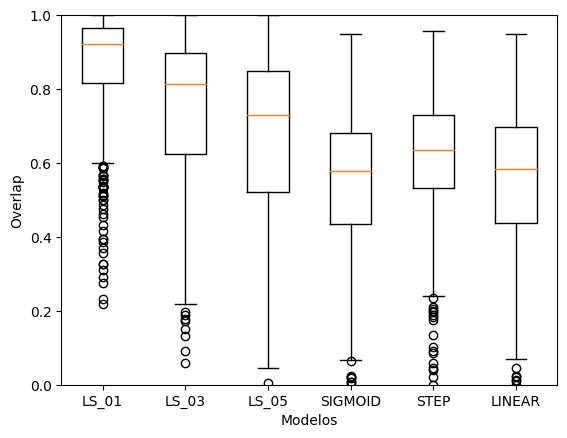

_LS_01 IG: 0.8795 ± 0.1239
_LS_03 IG: 0.7717 ± 0.1829
_LS_05 IG: 0.7177 ± 0.1813
_SIGMOID IG: 0.5813 ± 0.1165
_STEP IG: 0.6520 ± 0.0964
_LINEAR IG: 0.6047 ± 0.1081


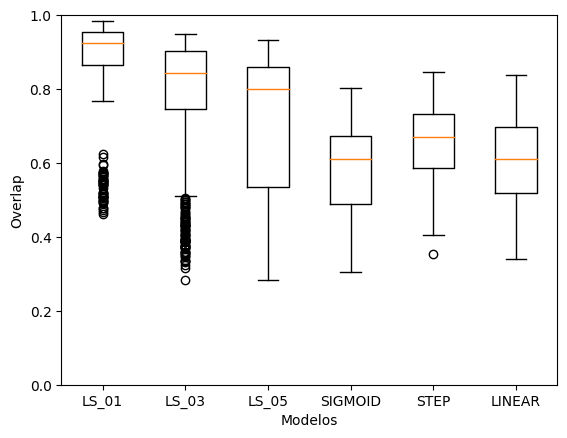

In [19]:
for xai in ["GC", "IG"]:

    test = []

    for model2 in ["_LS_01", "_LS_03", "_LS_05", "_SIGMOID", "_STEP", "_LINEAR"]:

        path_experiments2 = f'experiments\\{folder}\\{model1}{model2}'
        path_masks2 = os.path.join(path_experiments2, 'xai_masks')
        path_TP2 = os.path.join(path_experiments2, 'xai_masks', 'TP')
        path_TN2 = os.path.join(path_experiments2, 'xai_masks', 'TN')
        path_FP2 = os.path.join(path_experiments2, 'xai_masks', 'FP')
        path_FN2 = os.path.join(path_experiments2, 'xai_masks', 'FN')

        all_path2 = []
        all_path2.extend(os.listdir(path_TP2))
        all_path2.extend(os.listdir(path_TN2))
        all_path2.extend(os.listdir(path_FP2))
        all_path2.extend(os.listdir(path_FN2))

        all_path2.sort()

        mse = []

        for path1, path2 in zip(all_path1, all_path2):
            if path1.endswith('.pkl') and path2.endswith('.pkl'): 
                
                split1 = path1.split("_")
                split2 = path2.split("_")

                if split1[0] == split2[0] and split1[4] == xai and split2[4] == xai:

                    if split1[5] == "1" and split1[6] == "1":
                        path = path_TP1
                    elif split1[5] == "0" and split1[6] == "0":
                        path = path_TN1
                    elif split1[5] == "1" and split1[6] == "0":
                        path = path_FN1
                    elif split1[5] == "0" and split1[6] == "1":
                        path = path_FP1

                    with open(os.path.join(path, path1), 'rb') as f:
                        mask_1 = pickle.load(f)

                    if split2[5] == "1" and split2[6] == "1":
                        path = path_TP2
                    elif split2[5] == "0" and split2[6] == "0":
                        path = path_TN2
                    elif split2[5] == "1" and split2[6] == "0":
                        path = path_FN2
                    elif split2[5] == "0" and split2[6] == "1":
                        path = path_FP2

                    with open(os.path.join(path, path2), 'rb') as f:
                        mask_2 = pickle.load(f)

                    if mask_1.mean() !=0 and mask_2.mean() !=0:

                        mask_1 = processing(mask_1, mode)
                        mask_2 = processing(mask_2, mode)

                        #mse.append(overlap_schiller(mask_1, mask_2))
                        mse.append(IoU(mask_1, mask_2))
        
        mse = np.array(mse)

        print(f"{model2} {xai}: {(mse.mean()):.4f} ± {mse.std():.4f}")
        test.append(mse)

    # Create a box plot
    plt.boxplot(test, labels=["LS_01", "LS_03", "LS_05", "SIGMOID", "STEP", "LINEAR"])

    # Set plot labels and title
    plt.xlabel('Modelos')
    plt.ylabel('Overlap')
    plt.ylim([0, 1])

    # Show the plot
    plt.show()

In [20]:
for xai in ["GC", "IG"]:

    print(xai)

    for model2 in ["", "_LS_01", "_LS_03", "_LS_05", "_SIGMOID", "_STEP", "_LINEAR"]:

        path_experiments = f'experiments\\{folder}\\{model1}{model2}'
        path_masks = os.path.join(path_experiments, 'xai_masks')

        conf_N = np.arange(0.0, 0.51, 0.1).round(1)
        conf_P = np.arange(0.5, 1.01, 0.1).round(1)

        s = ''

        for confs, u in zip([conf_N, conf_P], ["N", "P"]):
            mse = []

            for c in range(len(confs)-1):
                path_1 = os.path.join(path_masks, "mean_masks", f"MEAN_{xai}_T{u}_{confs[c]}_{confs[c+1]}.pkl")
                path_2 = os.path.join(path_masks, "mean_masks", f"MEAN_{xai}_F{u}_{confs[c]}_{confs[c+1]}.pkl")

                try:
                    with open(path_1, 'rb') as f:
                        mask_1 = pickle.load(f)
                except FileNotFoundError:
                    mask_1 = np.zeros((512,512))

                try:
                    with open(path_2, 'rb') as f:
                        mask_2 = pickle.load(f)
                except FileNotFoundError:
                    mask_2 = np.zeros((512,512))

                if mask_1.mean() !=0 and mask_2.mean() != 0:

                    mask_1 = processing(mask_1, post=True)
                    mask_2 = processing(mask_2, post=True)

    
                    #diff = round(overlap_schiller(mask_1, mask_2), 4)
                    diff = round(IoU(mask_1, mask_2), 4)


                    #plt.figure()
                    #plt.imshow(mask_1, cmap='Reds', alpha=0.5)
                    #plt.imshow(mask_2, cmap='Blues', alpha=0.5)
                    #plt.title(diff)
                    #plt.show()

                    s = s + ';' + str(diff).replace('.',',')
                else:
                    s = s + ';' + '-'

            
        print(s)

GC
;0,5595;0,4578;0,4308;0,5312;0,7218;0,4291;0,4358;0,5193;0,7419;0,8224
;0,5205;0,4134;0,5493;0,5257;0,7412;0,5548;0,4958;0,633;0,6014;0,3985
;-;0,4327;0,4642;0,4633;0,6612;0,4427;0,6391;0,7416;0,5374;-
;-;-;0,5261;0,475;0,7525;0,5728;0,5898;0,6876;-;-
;-;0,4484;0,4026;0,6082;0,5263;0,4875;0,6077;0,712;0,7972;-
;0,2069;0,3377;0,4609;0,4221;0,4649;0,3421;0,6568;0,5762;0,708;0,4374
;0,4029;0,436;0,4917;0,5763;0,5086;0,6154;0,4876;0,7402;0,6731;-
IG
;0,4657;0,4574;0,3609;0,4289;0,4187;0,3377;0,2552;0,3324;0,2674;0,3231
;0,3904;0,3996;0,4422;0,3578;0,4312;0,3397;0,2323;0,3201;0,35;0,2137
;-;0,4171;0,4268;0,4506;0,494;0,2449;0,3172;0,401;0,2558;-
;-;-;0,3978;0,4708;0,5257;0,3465;0,4099;0,3003;-;-
;-;0,4225;0,3955;0,5082;0,4268;0,292;0,3542;0,3399;0,3459;-
;0,2212;0,4232;0,4919;0,4464;0,4194;0,3548;0,3537;0,3776;0,3557;0,2115
;0,3573;0,3499;0,5117;0,4223;0,3508;0,3565;0,283;0,3406;0,3192;-
